## Setup

In this step we:

* Specify the Amazon SageMaker role Amazon Resource Name (ARN) used to give learning and hosting access to your data.
* Specify the Amazon S3 bucket that will be used for training and storing model objects.
* Install liac-arff package as the provided dataset uses Attribute-Relation File Format (ARFF).

In [1]:
import os
import boto3
import time
import re
from sagemaker import get_execution_role
#!pip install --upgrade pip
#!pip install liac-arff

role = get_execution_role()

Now you need to import the relevant Python libraries that we’ll use throughout the analysis.

In [2]:
import pandas as pd                               # For munging tabular data
import numpy as np                                # For matrix operations and numerical processing
import matplotlib.pyplot as plt                   # For charts and visualizations
import io                                         # For working with stream data
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import json                                       # For parsing hosting output
import sagemaker.amazon.common as smac            # For protobuf data format
import arff                                       # For installing Liac-arff module (https://pypi.python.org/pypi/liac-arff) that implements functions to read and write ARFF files in Python
import csv                                        # For converting ARFF to CSV for AWS S3 to read
from random import shuffle                        # For randomizing or shuffling data
import requests, zipfile                          # For unzipping and extracting files from zipped files
import sklearn as sk                              # For access to a variety of machine learning models
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from sklearn.datasets import dump_svmlight_file   # For outputting data to libsvm format for xgboost
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function

Let’s define the Amazon S3 bucket used for the example.

In [3]:
#  Enter your s3 bucket where you will copy data and model artificats
bucket = 'labstack-prewarm-c47c025d-c319-469b-b0-readimages-1xtu33k7vxxex'
prefix = 'sagemaker/xgboost-multiclass'  #Training files will be uploaded in this location within the bucket

---
## Data

Data for this Challenge is in two separate files: column_2c_weka.arff and column_3c_weka.arff. The column names are in both files. column_2C_weka.arff for binary classification and column_3C_weka.arff for categorical classification. The dataset consists of 310 rows representing 310 patient records.

---

### Classes and Attributes
The dataset includes six biomechanical attributes of the patient and the outcome or pathology. The attributes describe the vertebral column (group of vertebras, invertebrate discs, nerves, muscles, medulla and joints). These spino-pelvic system parameters include angle of pelvic incidence (PI), angle of pelvic tilt (PT), lordosis angle, sacral slope (SS), pelvic radius, and grade of slipping.

Each patient has six biomechanical attributes derived from the shape and orientation of the pelvis and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle, sacral slope, pelvic radius, and grade of spondylolisthesis. There is also a class or diagnosis for each patient–either binary: Normal (NO) and Abnormal (AB) or multiclass: DH (Disk Hernia), Spondylolisthesis (SL), Normal (NO).

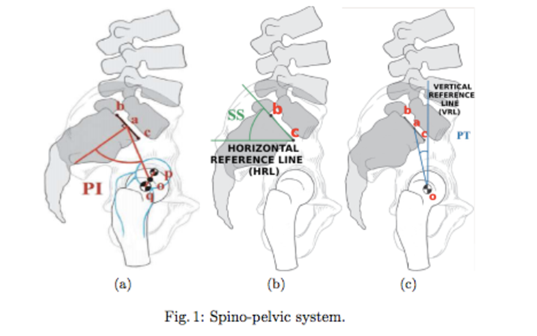

## Prepare: 

To get the data into Amazon S3 in a format that XGBoost can read, we extract the relevant files from the zipped file, convert to CSV, and add them to the Amazon S3 bucket so that S3 and Amazon SageMaker can read them.

#### Extract Files and Read Data Pre-Conversion

####  Read Data Pre-Conversion

In [4]:

# Reading Arff --> Data --> Binary/Categorical Conversion --> CSV
data_dict = arff.load(open('column_3C_weka.arff', 'r')) #Read arff for multiclass
data_arff = data_dict["data"]                           #List of Datapoints only

#### Conversion
Now we take the extracted file and convert it into .csv files in the proper format (Ortho_dataset.csv for binary and Ortho_dataset_2.csv for multi-class). XGBoost requires binary attributes to be classified as 0 and 1. Therefore, in the binary classification file, I replaced “Abnormal” and “Normal” with “1” and “0” in the class variable column ‘diagnosis’, and in the multi-class categorical classification file, we replaced “Normal”, “Hernia”, and “Spondylolisthesis” with “0,” “1,” “2,” respectively.

See the following Python script to read the .arff file and convert it to .csv format.


In [5]:
shuffle(data_arff) #Shuffle the patients within the dataset 
attributes_tup = data_dict["attributes"] #Extract attribute tuples
Attributes = []
for i in attributes_tup: #Extract only relevant attribute names
    for tup in i[::2]: 
        Attributes.append(tup)

Ortho_dataset_2= [Attributes]+ data_arff

In [6]:
## Changing to categorical  values : "Hernia" to 1 and "Normal" to 0, "Spondylolisthesis" to 2
for row in Ortho_dataset_2: 
    for i in row: 
        if i == "Hernia":
            row.remove(i)
            row.append("1")
        if i == "Normal": 
            row.remove(i)
            row.append("0")
        if i == "Spondylolisthesis": 
            row.remove(i)
            row.append("2")              
 

In [7]:
           
#Writing dataset to CSV 
def writeCsvFile(filename, dataset): 
    """
    @filename: string, filname to save it as
    @dataset: list of list of items

    Write data to file
    """
    mycsv = csv.writer(open(filename, 'w'))
    for row in dataset:
        mycsv.writerow(row)
 

In [8]:
##For Multi-class:
writeCsvFile('Ortho_dataset_2.csv', Ortho_dataset_2)

In [9]:
# read the data
data = pd.read_csv('Ortho_dataset_2.csv', header = 0) #Header is zero to indicate first row's column headers

In [10]:
# save the data
data.to_csv("Mdata.csv", sep=',', index=False)

In [11]:
# read test data
data_test = pd.read_csv('Ortho_dataset_2.csv', header = 0, skiprows=0) #Header is zero to indicate first row's column headers

In [12]:
# set column names
data.columns = ["pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle","sacral_slope","pelvic_radius",
                     "degree_spondylolisthesis","diagnosis"] 

In [13]:
data_test.columns = ["pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle","sacral_slope","pelvic_radius",
                     "degree_spondylolisthesis","diagnosis"] 

In [14]:
##Create data bins to move diagnosis column to the first column
diagnosis_col = data.iloc[:,6]  #Diagnosis columns

In [15]:
#Creating new dataframe with diagnosis as first column

mdata_test_bin = pd.concat([diagnosis_col, data_test.iloc[:, 0:6]], axis=1) 
mdata_bin = pd.concat([diagnosis_col, data.iloc[:, 0:6]], axis = 1)

In [16]:
# Set column names for dataframes

mdata_bin.columns = ["diagnosis","pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle","sacral_slope","pelvic_radius",
                     "degree_spondylolisthesis"] 


mdata_test_bin.columns = ["diagnosis","pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle","sacral_slope","pelvic_radius",
                     "degree_spondylolisthesis"] 

## Exploration

Now we’ll explore the dataset to understand the size of data, the various fields, the values that different features take, and the distribution of target values.                                          

### Data exploration and transformations

For an effective ML model and potentially for higher accuracy, the more data the better.

In [17]:
# set display options
pd.set_option('display.max_columns', 100)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 6)         # Keep the output on one page

display(data_test.iloc[:,6].value_counts())

# count number of positives and negatives
display(mdata_bin.iloc[:,0].value_counts())
print("data_test:")
display(mdata_test_bin.iloc[:,0].value_counts())

2    150
0    100
1     60
Name: diagnosis, dtype: int64

2    150
0    100
1     60
Name: diagnosis, dtype: int64

data_test:


2    150
0    100
1     60
Name: diagnosis, dtype: int64

### Data Histograms and Correlation

Here we can visualize the data to see the spread of data within each feature in a histogram and scatter matrix. The scatter-plot matrix displays the correlation between pairs of variables. The matrix makes it easy to look at all pairwise correlations in one place.

,diagnosis,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,1.161290,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,0.884852,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
...,...,...,...,...,...,...,...
50%,1.000000,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,2.000000,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,2.000000,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


,diagnosis,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
diagnosis,1.000000,0.537638,0.348231,0.525466,0.430734,-0.304099,0.608705
pelvic_incidence,0.537638,1.000000,0.629199,0.717282,0.814960,-0.247467,0.638743
pelvic_tilt,0.348231,0.629199,1.000000,0.432764,0.062345,0.032668,0.397862
...,...,...,...,...,...,...,...
sacral_slope,0.430734,0.814960,0.062345,0.598387,1.000000,-0.342128,0.523557
pelvic_radius,-0.304099,-0.247467,0.032668,-0.080344,-0.342128,1.000000,-0.026065
degree_spondylolisthesis,0.608705,0.638743,0.397862,0.533667,0.523557,-0.026065,1.000000


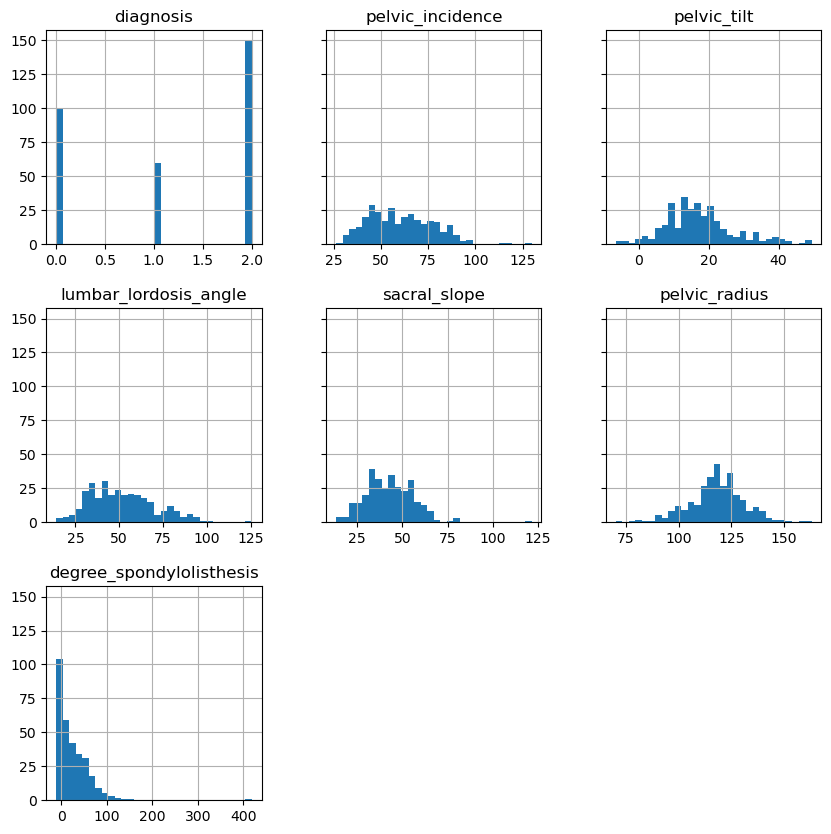

In [19]:
# Histograms for each numeric features
display(mdata_bin.describe())
%matplotlib inline
hist = mdata_bin.hist(bins=30, sharey=True, figsize=(10, 10))

##correlation
display(mdata_bin.corr())
#<<TASK 2 INPUT REQUIRED>>
plt.show()

### Data Description
Let's talk about the data.  At a high level, we can see:

* There are 7 columns and around 217 rows in the training data
* There are 7 columns and around 93 rows in the test data
* Diagnosis is the target field

_**Specifics on the features:**_ 
* 6 out of 6 features are numeric

**Target variable:**
* `diagnosis: 
    MultiClass: Whether the patient has Hernia, Spondylosisthesis or is Normal or 
    Binary: Whether or not the patient has a abnormal spine condition

---

## Training

For our first training algorithm we use the xgboost algorithm. xgboost is an extremely popular, open-source package for gradient boosted trees. It’s computationally powerful, fully featured, and has been successfully used in many machine learning competitions. Let’s start with a simple xgboost model, trained using the Amazon SageMaker managed, distributed training framework.

First we’ll need to specify training parameters. These include the following:

   * The role to use
   * Our training job name
   * The xgboost algorithm container
   * Training instance type and count
   * S3 location for training data
   * S3 location for output data
   * Algorithm hyperparameters

The supported training input format is csv, libsvm. For csv input, we assume that the input is separated by delimiters (automatically detect the separator using Python’s built-in sniffer tool), without a header line, and the label is in the first column. The Scoring Output Format is csv. Our data is in CSV format, so we’ll convert our dataset to the way that the Amazon SageMaker XGBoost supports. We will keep the target field in first column and remaining features in the next few columns. We will remove the header line. We will also split the data into a separate training and validation sets. Finally, we’ll store the data in our S3 bucket.

#### Split the data into 70% training and 15% validation and save it before calling XGboost

In [20]:
# Split the data randomly as 70% for training and remaining 20% and save them locally
mtrain_list = np.random.rand(len(mdata_bin)) < 0.7
mdata_train = mdata_bin[mtrain_list]
mdata_val = mdata_bin[~mtrain_list]
mdata_train.to_csv("mformatted_train.csv", sep=',', header=False, index=False) # save training data 
mdata_val.to_csv("mformatted_val.csv", sep=',', header=False, index=False) # save validation data
mdata_test_bin.to_csv("mformatted_test.csv", sep=',', header=False,  index=False) # save test data


#### Upload training and validation data sets in the s3 bucket and prefix provided


In [21]:

mtrain_file = 'mformatted_train.csv'
mval_file = 'mformatted_val.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/', mtrain_file)).upload_file(mtrain_file)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'val/', mval_file)).upload_file(mval_file)


#### Specify parameters based on the model
* Multiclass: objective: "multi:softmax", num_class: "3"
* Binary: objective: "binary:logistic", eval_metric: "error@t" (where t is the score threshold of error)

In [22]:
Mxgboost_containers = {'us-west-2' : '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
                    'us-east-1' : '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
                    'us-east-2' : '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
                    'eu-west-1' : '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}

In [23]:
import boto3
from time import gmtime, strftime

mjob_name = 'Mxgboost-ortho' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", mjob_name)

mcreate_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": Mxgboost_containers[boto3.Session().region_name],
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/single-xgboost/".format(bucket, prefix),
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m4.4xlarge",
        "VolumeSizeInGB": 1000
    },
    "TrainingJobName": mjob_name,
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.1",
        "gamma":"1",
        "min_child_weight":"1",
        "silent":"0",
        "objective": "multi:softmax", #for multiclass
        "num_round": "20",
        "num_class": "3", #remove if not multiclass
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri":  "s3://{}/{}/train/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/val/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        }
    ]
}



Training job Mxgboost-ortho2023-06-12-17-25-39


In [ ]:

%%time

region = boto3.Session().region_name
sm = boto3.client('sagemaker')

sm.create_training_job(**mcreate_training_params)
    
#<<TASK 3 INPUT REQUIRED>>

status = sm.describe_training_job(TrainingJobName=mjob_name)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=mjob_name)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=mjob_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')  
    
# Estimated Time: ~6 minutes    

InProgress


---

## Hosting

Now that we've trained the `xgboost` algorithm on our data, let's setup a model which can later be hosted.  We will:
1. Point to the scoring container
1. Point to the model.tar.gz that came from training
1. Create the hosting model

In [31]:
model_name=mjob_name + '-mdl'
Mxgboost_hosting_container = {
    'Image': Mxgboost_containers[boto3.Session().region_name],
    'ModelDataUrl': sm.describe_training_job(TrainingJobName=mjob_name)['ModelArtifacts']['S3ModelArtifacts'],
    'Environment': {'this': 'is'}
}

create_model_response = sm.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer=Mxgboost_hosting_container)

In [32]:
print(create_model_response['ModelArn'])
print(sm.describe_training_job(TrainingJobName=mjob_name)['ModelArtifacts']['S3ModelArtifacts'])

arn:aws:sagemaker:us-east-1:168731883384:model/mxgboost-ortho2023-06-12-17-25-39-mdl
s3://labstack-prewarm-c47c025d-c319-469b-b0-readimages-1xtu33k7vxxex/sagemaker/xgboost-multiclass/single-xgboost/Mxgboost-ortho2023-06-12-17-25-39/output/model.tar.gz


After we set up a model, we can configure what our hosting endpoints should be. Here we specify the following:

  1. EC2 instance type to use for hosting.
  2. Initial number of instances.
  3. Our hosting model name.


In [33]:
from time import gmtime, strftime

mendpoint_config_name = 'MXGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(mendpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = mendpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'InitialVariantWeight':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

MXGBoostEndpointConfig-2023-06-12-18-34-35
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:168731883384:endpoint-config/mxgboostendpointconfig-2023-06-12-18-34-35


### Create endpoint
Lastly, we create the endpoint that serves up the model, through specifying the name and configuration defined earlier. The end result is an endpoint that can be validated and incorporated into production applications. This takes about 7-11 minutes to complete.

In [35]:
%%time
import time

mendpoint_name = 'MXGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(mendpoint_name)
create_endpoint_response = sm.create_endpoint(
    EndpointName=mendpoint_name,
    EndpointConfigName=mendpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=mendpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=mendpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

# Estimated Time: ~10 minutes

MXGBoostEndpoint-2023-06-12-18-37-43
arn:aws:sagemaker:us-east-1:168731883384:endpoint/mxgboostendpoint-2023-06-12-18-37-43
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:168731883384:endpoint/mxgboostendpoint-2023-06-12-18-37-43
Status: InService
CPU times: user 267 ms, sys: 2.35 ms, total: 270 ms
Wall time: 4min 1s


### Prediction
 Here is the model that was created is used to predict values


In [36]:
runtime= boto3.client('runtime.sagemaker')

In [37]:
# Simple function to create a csv from our numpy array

def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()


In [38]:
# Function to generate prediction through sample data
def do_predict(data, endpoint_name, content_type):
    
    payload = np2csv(data)
    response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    preds = [float((num)) for num in result]
    return preds

# Function to iterate through a larger data set and generate batch predictions
def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            datav = data.iloc[offset:(offset+batch_size),:].values
            results = do_predict(datav, endpoint_name, content_type)
            arrs.extend(results)
        else:
            datav = data.iloc[offset:items,:].values
            arrs.extend(do_predict(datav, endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [39]:
### read the saved data for scoring
mdata_train = pd.read_csv("mformatted_train.csv", sep=',', header=None) 
mdata_test = pd.read_csv("mformatted_test.csv", sep=',', header=None) 
mdata_val = pd.read_csv("mformatted_val.csv", sep=',', header=None) 
# display(mdata_val.iloc[:,0].value_counts())

### Generate predictions on train, validation and test sets

In [40]:
mpreds_train_xgb = batch_predict(mdata_train.iloc[:, 1:], 1000, mendpoint_name, 'text/csv')
mpreds_val_xgb = batch_predict(mdata_val.iloc[:, 1:], 1000, mendpoint_name, 'text/csv')
mpreds_test_xgb = batch_predict(mdata_test.iloc[:,1:],1000, mendpoint_name, 'text/csv')



...

---
## Evaluate Model Accuracy for Multiclass Categorical

There are many ways to compare the performance of a machine learning model.

For multiclass models, typically we use the F1 measure and not the AUC score, area under the ROC curve which is typically used in binary models. The F1 measure is a statistical measure of the precision and recall of all the classes in the model. The score ranges from 0 to 1; the higher the score, the better the accuracy of the model. For example, an F1 score of ~0.9 would indicate a better model than a score of 0.7.

Other evaluation metrics include Sensitivity, or true positive rate, and Precision, or positive predictive value. This will be covered more in depth in the binary classification example.


In [41]:
from sklearn import metrics
mtrain_labels = mdata_train.iloc[:,0];
mval_labels = mdata_val.iloc[:,0];
mtest_labels = mdata_test.iloc[:,0];

Training_f1 = metrics.f1_score(mtrain_labels, mpreds_train_xgb, average=None)
Validation_f1= metrics.f1_score(mval_labels, mpreds_val_xgb, average=None)
# fbeta_test= metrics.f1_score(mtest_labels, mpreds_test_xgb, average=None)
prec, rec, fbeta_test, support = metrics.precision_recall_fscore_support(mtest_labels, mpreds_test_xgb, average = None)
metrics.precision_recall_fscore_support(mtest_labels, mpreds_test_xgb, average = None)

print("Average Training F1 Score", (Training_f1[0]+Training_f1[1]+Training_f1[2])/3) ##0.95594
print("Average Validation F1 Score", (Validation_f1[0]+Validation_f1[1]+Validation_f1[2])/3) ##0.7922

print ("Test Evaluation: ")
print ("Average F1 Score: ", (fbeta_test[0]+fbeta_test[1]+fbeta_test[2])/3 ) ##0.91
print ("Normal F1 Score: ", fbeta_test[0]) ## 0.8944
print ("Hernia F1 Score: ", fbeta_test[1]) ## 0.8524
print ("Spondylosisthesis F1 Score: ", fbeta_test[2]) ## 0.9832
print ("Average Precision Score: ", (prec[0]+prec[1]+prec[2])/3 )##0.91
print ("Average Sensitivity/TPR Score: ", (rec[0]+rec[1]+rec[2])/3 )##0.91


Average Training F1 Score 0.9577794465858869
Average Validation F1 Score 0.7423677616448701
Test Evaluation: 
Average F1 Score:  0.8885068608758168
Normal F1 Score:  0.8785046728971964
Hernia F1 Score:  0.8037383177570094
Spondylosisthesis F1 Score:  0.9832775919732442
Average Precision Score:  0.9086774005793674
Average Sensitivity/TPR Score:  0.8788888888888889


This ML model received an average F1 score of 0.94. 

## Confusion Matrix

You can also delve into the performance for each class by looking at the confusion matrix.

The confusion matrix provides a visual representation of the performance based on the accuracy of the multiclass classification predictive model. In this table you can find the percentage of true positives and false positives.

In [42]:
import itertools
         
class_names = ["Normal","Hernia", "Spondylosisthesis"]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


For example, you see class (or diagnosis) Spondylosisthesis had a high accuracy rate (99%) with 149 cases out of 150 cases predicted correctly in the evaluation dataset. The F1 score of 0.98 is also relatively high. However, class Hernia had a lower F1 score of 0.85 showing that the model confused it with the Normal pathology. For more information on multiclass model evaluation and insights, go to Multiclass Model Insights: https://docs.aws.amazon.com/machine-learning/latest/dg/multiclass-model-insights.html. 
 

Confusion matrix, without normalization
[[ 94   4   2]
 [ 17  43   0]
 [  3   0 147]]
Normalized confusion matrix
[[0.94 0.04 0.02]
 [0.28 0.72 0.  ]
 [0.02 0.   0.98]]


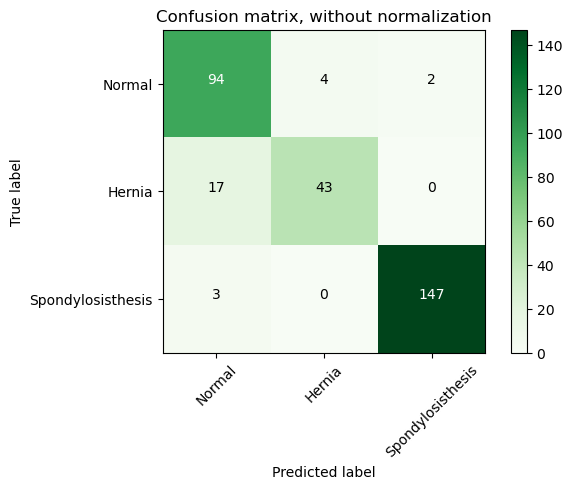

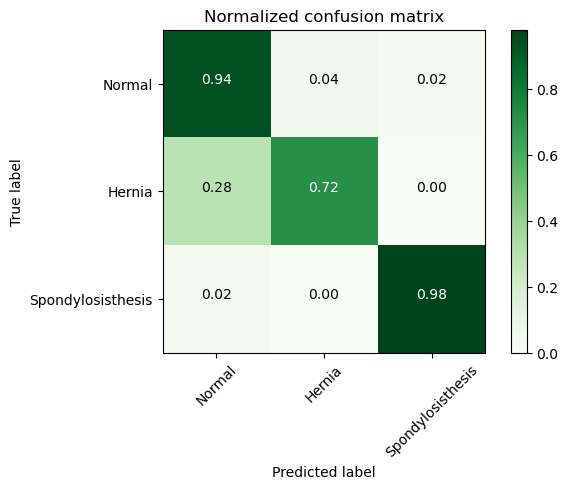

In [43]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(mtest_labels, mpreds_test_xgb)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
#Confusion matrix, without normalization
# [[ 89   9   2]
#  [  8  52   0]
#  [  2   1 147]]
# Normalized confusion matrix
# [[ 0.89  0.09  0.02]
#  [ 0.13  0.87  0.  ]
#  [ 0.01  0.01  0.98]]

## Binary Classification Model 


The binary classification model yields a binary response (0 or 1)—in this case, 0 was normal and 1 was abnormal. The evaluation produces the below four statistics in a similar confusion matrix. 

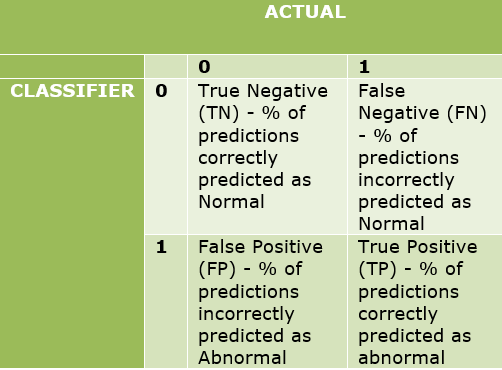
